In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from keras.models import load_model
from bridgescaler import load_scaler
import pandas as pd
from sealsml.data import Preprocessor
import numpy as np
import copy
import yaml

2024-05-28 08:49:46.233247: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 08:49:47.085162: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load trained transformer model

In [2]:
path_mlmodel = '/glade/derecho/scratch/domingom/SEALS_ML/test_train_v4/train_transformer/2024-05-23_1736/'
mlmodel_transformer = 'transformer_leak_loc_2024-05-23_1736.keras'
mlmodel_scaler = 'scaler_2024-05-23_1736.json'
mlmodel_specs = '/glade/derecho/scratch/domingom/SEALS_ML/test_train_v4/train_transformer_DME.yaml'

model_tmp = path_mlmodel + mlmodel_transformer
scaler_tmp = path_mlmodel + mlmodel_scaler
print('scaler_tmp=',scaler_tmp)
print('model_tmp=',model_tmp)

scaler_tmp= /glade/derecho/scratch/domingom/SEALS_ML/test_train_v4/train_transformer/2024-05-23_1736/scaler_2024-05-23_1736.json
model_tmp= /glade/derecho/scratch/domingom/SEALS_ML/test_train_v4/train_transformer/2024-05-23_1736/transformer_leak_loc_2024-05-23_1736.keras


In [3]:
scaler = load_scaler(scaler_tmp)
model = load_model(model_tmp)

2024-05-28 08:49:52.471352: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
scaler

In [5]:
model

<QuantizedTransformer name=quantized_transformer, built=True>

# Load testing instance/s

In [6]:
val_files = pd.read_csv("/glade/derecho/scratch/domingom/SEALS_ML/test_train_v4/train_transformer/validation_files.csv")

In [7]:
val_files.loc[0,'validation_files']

'/glade/derecho/scratch/domingom/SEALS_ML/test_datagen_v2/SEALS_training_data_Sample/data_gen_20240320/training_data_DC_Ug7p5_src_9_10kg_hour_12.0.nc'

In [8]:
num_val_files = len(val_files)
print('num_val_files=',num_val_files)

num_val_files= 65


In [9]:
# read in sensor_pad_value and sensor_type_value values
with open(mlmodel_specs) as config_file:
    config_mlmodel = yaml.safe_load(config_file)
config_mlmodel

{'data_path': '/glade/derecho/scratch/domingom/SEALS_ML/test_datagen_v2/SEALS_training_data_Sample/data_gen_20240320/',
 'out_path': '/glade/derecho/scratch/domingom/SEALS_ML/test_train_v4/train_transformer/',
 'random_seed': 812,
 'save_model': True,
 'save_output': True,
 'validation_ratio': 0.3,
 'sensor_type_mask': -999,
 'sensor_exist_mask': -1,
 'scaler_type': 'quantile',
 'models': ['transformer_leak_loc'],
 'transformer_leak_loc': {'kwargs': {'encoder_layers': 2,
   'decoder_layers': 2,
   'hidden_size': 128,
   'n_heads': 8,
   'num_quantized_embeddings': 500,
   'hidden_activation': 'relu',
   'output_activation': 'sigmoid',
   'dropout_rate': 0.2,
   'use_quantizer': 0,
   'quantized_beta': 0.25,
   'n_outputs': 1,
   'min_filters': 4,
   'kernel_size': 3,
   'filter_growth_rate': 2,
   'n_conv_layers': 3,
   'pooling': 'average',
   'pool_size': 2,
   'padding': 'valid'},
  'fit': {'epochs': 70, 'verbose': 1, 'batch_size': 1024},
  'compile': {'loss': 'binary_crossentropy',

In [10]:
pre = Preprocessor(scaler_type="quantile", sensor_pad_value=config_mlmodel['sensor_exist_mask'],\
                   sensor_type_value=config_mlmodel['sensor_type_mask'])
val_encoder, val_decoder, target_potleak, leak_rate = pre.load_data(val_files["validation_files"].values)
print('val_encoder.shape=',val_encoder.shape)
print('val_decoder.shape=',val_decoder.shape)
print('target_potleak.shape=',target_potleak.shape)
print('leak_rate.shape=',leak_rate.shape)

val_encoder.shape= (97500, 10, 100, 8, 2)
val_decoder.shape= (97500, 20, 1, 8, 2)
target_potleak.shape= (97500, 20)
leak_rate.shape= (97500,)


In [11]:
pre.scaler = scaler
val_encoder_s, val_encoder_mask = pre.preprocess(val_encoder, fit_scaler=False)
val_decoder_s, val_decoder_mask = pre.preprocess(val_decoder, fit_scaler=False)
print('## After scaler pre-processing ##')
print('val_encoder_s.shape=',val_encoder_s.shape)
print('val_encoder_mask.shape=',val_encoder_mask.shape)
print('val_decoder_s.shape=',val_decoder_s.shape)
print('val_decoder_mask.shape=',val_decoder_mask.shape)

## After scaler pre-processing ##
val_encoder_s.shape= (97500, 10, 100, 8)
val_encoder_mask.shape= (97500, 10)
val_decoder_s.shape= (97500, 20, 8)
val_decoder_mask.shape= (97500, 20)


In [12]:
samples_per_file = int(val_encoder.shape[0]/num_val_files)
print('samples_per_file=',samples_per_file)

samples_per_file= 1500


In [13]:
# Histogram of sensors
val_encoder_mask_ME = np.zeros(val_encoder_mask.shape, dtype=int)
print('val_encoder_mask_ME.shape=',val_encoder_mask_ME.shape)
val_encoder_mask_ME[val_encoder_mask == True] = 1
num_senors = np.sum(val_encoder_mask_ME,axis=1)
print('num_senors.shape=',num_senors.shape)

val_encoder_mask_ME.shape= (97500, 10)
num_senors.shape= (97500,)


bin_min,bin_max= 5 , 10
bins_tmp= [ 4.5  5.5  6.5  7.5  8.5  9.5 10.5]
np.sum(hist)= 97500


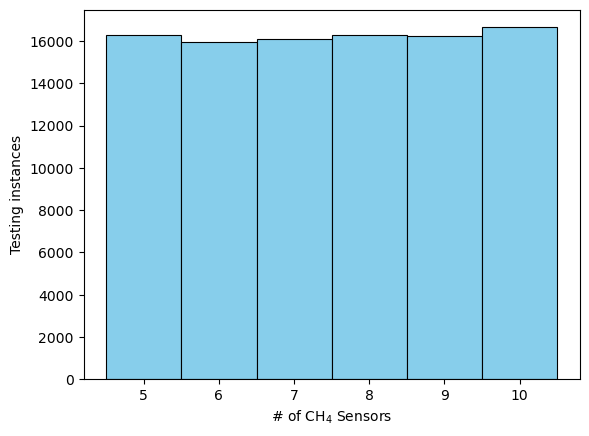

In [14]:
bin_min = np.min(num_senors)
bin_max = np.max(num_senors)
print('bin_min,bin_max=',bin_min,',',bin_max)
bins_tmp = np.arange(bin_min-0.5,bin_max+1.5)
print('bins_tmp=',bins_tmp)
#
hist, bin_edges = np.histogram(num_senors, bins=bins_tmp)
print('np.sum(hist)=',np.sum(hist))
#
plt.hist(num_senors,bins=bin_edges,edgecolor='black', linewidth=0.8,color='skyblue')
plt.xlabel('# of CH$_4$ Sensors')
plt.ylabel('Testing instances')
plt.show()

In [15]:
# Histogram of potential leaks
val_decoder_mask_ME = np.zeros(val_decoder_mask.shape, dtype=int)
print('val_decoder_mask_ME.shape=',val_decoder_mask_ME.shape)
val_decoder_mask_ME[val_decoder_mask == True] = 1
num_potleaks = np.sum(val_decoder_mask_ME,axis=1)
print('num_potleaks.shape=',num_potleaks.shape)

val_decoder_mask_ME.shape= (97500, 20)
num_potleaks.shape= (97500,)


bin_min,bin_max= 5 , 20
bins_tmp= [ 4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5
 18.5 19.5 20.5]
np.sum(hist)= 97500


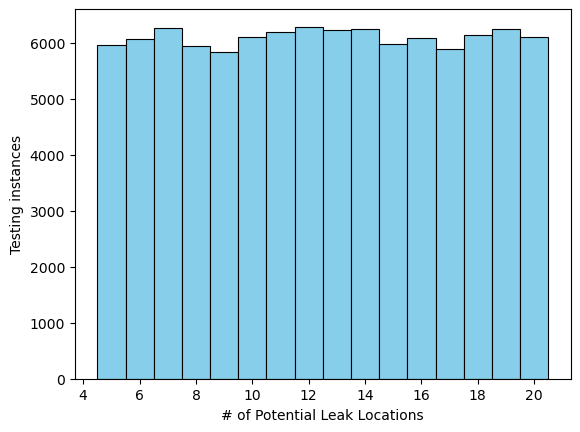

In [16]:
bin_min = np.min(num_potleaks)
bin_max = np.max(num_potleaks)
print('bin_min,bin_max=',bin_min,',',bin_max)
bins_tmp = np.arange(bin_min-0.5,bin_max+1.5)
print('bins_tmp=',bins_tmp)
#
hist, bin_edges = np.histogram(num_potleaks, bins=bins_tmp)
print('np.sum(hist)=',np.sum(hist))
#
plt.hist(num_potleaks,bins=bin_edges,edgecolor='black', linewidth=0.8,color='skyblue')
plt.xlabel('# of Potential Leak Locations')
plt.ylabel('Testing instances')
plt.show()

# ML model predictions

In [17]:
pred = model.predict([val_encoder_s, val_decoder_s[..., 0:5], val_encoder_mask, val_decoder_mask]) # , batch_size=1024)

I0000 00:00:1716907850.911332   31106 service.cc:145] XLA service 0x1482ec017840 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716907850.911370   31106 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-05-28 08:50:51.011864: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


   3/3047 ━━━━━━━━━━━━━━━━━━━━ 1:51 37ms/step 

I0000 00:00:1716907852.865402   31106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3047/3047 ━━━━━━━━━━━━━━━━━━━━ 102s 33ms/step


In [18]:
print('pred.shape=',pred.shape)

pred.shape= (97500, 20, 1)


# Plot a specific prediction instance

In [19]:
ii = 207

In [20]:
print('num_senors=',num_senors[ii])
print('num_potleaks=',num_potleaks[ii])

num_senors= 7
num_potleaks= 10


Text(0.5, 1.0, 'SEALS Transformer (n$_{sens}$=7, n$_{leak}$=10)')

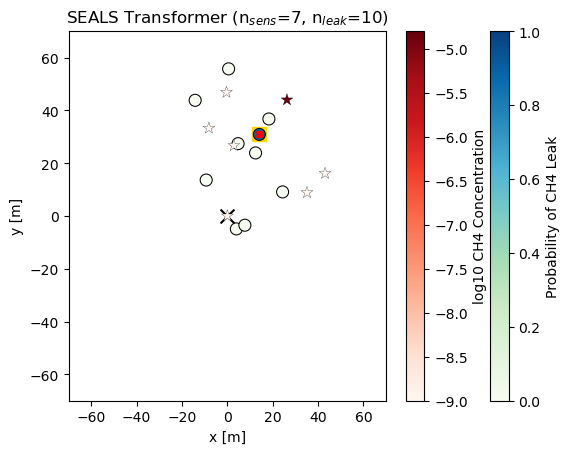

In [21]:
mask = val_decoder_mask[ii]
plt.scatter(val_decoder[ii, :, 0, 0, 0].values[mask] * val_decoder[ii, :, 0, 2, 0].values[mask], 
            val_decoder[ii, :, 0, 0, 0].values[mask] * val_decoder[ii, :, 0, 1, 0].values[mask], 75, pred[ii,:][mask], 
            cmap="GnBu", vmin=0, vmax=1, linewidths=0.75,edgecolors='k')
plt.colorbar(label="Probability of CH4 Leak")
mask_en = val_encoder[ii, :, 0, -1, 0] > 0
plt.scatter(val_encoder[ii, :, 0, 0, 0].values[mask_en] * val_encoder[ii, :, 0, 2, 0].values[mask_en], 
            val_encoder[ii, :, 0, 0, 0].values[mask_en] * val_encoder[ii, :, 0, 1, 0].values[mask_en], 80, 
            np.log10(val_encoder[ii, :, :, -1, 0].max(axis=1).values[mask_en]), marker='*', cmap="Reds", linewidths=0.2,edgecolors='k')
plt.colorbar(label="log10 CH4 Concentration")

t = target_potleak[ii].argmax()
plt.scatter(val_decoder[ii, :, 0, 0, 0].values[t] * val_decoder[ii, :, 0, 2, 0].values[t], 
            val_decoder[ii, :, 0, 0, 0].values[t] * val_decoder[ii, :, 0, 1, 0].values[t], 100, marker='s', color='gold', zorder=0)

t_pred = pred[ii,:][mask].argmax()
plt.scatter(val_decoder[ii, :, 0, 0, 0].values[t_pred] * val_decoder[ii, :, 0, 2, 0].values[t_pred], 
            val_decoder[ii, :, 0, 0, 0].values[t_pred] * val_decoder[ii, :, 0, 1, 0].values[t_pred], 25, marker='X', color='red') # , zorder=0)

met_ind = np.where(val_encoder[ii,:,0,4,1].values==0.0)
plt.scatter(val_encoder[ii,:,0,0,0].values[met_ind] * val_encoder[ii,:,0,2,0].values[met_ind], 
            val_encoder[ii,:,0,0,0].values[met_ind] * val_encoder[ii,:,0,1,0].values[met_ind], 100, marker='x', color='black', zorder=0)

plt.xlim([-70,70])
plt.ylim([-70,70])

plt.xlabel('x [m]')
plt.ylabel('y [m]')

str_tmp = "SEALS Transformer (n$_{sens}$=" + str(num_senors[ii]) + ", n$_{leak}$=" + str(num_potleaks[ii]) + ")"
plt.title(str_tmp)
###plt.savefig(f"seals_case_{ii:d}.png", dpi=300, bbox_inches="tight")

In [22]:
#pred[ii,:]

# Fixed configuration skill analysis

In [23]:
n_sens = 10 # number of CH4 sensors
n_leak = 20 # number of potential leak locations

In [24]:
ind_sens = np.zeros(num_senors.shape)
ind_leak = np.zeros(num_potleaks.shape)
print('ind_sens.shape=',ind_sens.shape)

ind_sens.shape= (97500,)


In [25]:
ind_sens[np.where(num_senors==n_sens)] = 1.0
ind_leak[np.where(num_potleaks==n_leak)] = 1.0
print('np.sum(ind_sens)=',np.sum(ind_sens))
print('np.sum(ind_leak)=',np.sum(ind_leak))

np.sum(ind_sens)= 16644.0
np.sum(ind_leak)= 6093.0


In [26]:
ind_tot = ind_sens + ind_leak

In [27]:
ind_comb = np.where(ind_tot==2.0)
ind_comb = ind_comb[0]
n_comb = len(ind_comb)
#print('ind_comb=',ind_comb)
print('n_comb=',n_comb)

n_comb= 1078


In [28]:
error_conf = np.zeros([n_comb,1])

In [29]:
for tt in range(0,n_comb):
    t_pred_tt = pred[ind_comb[tt],:][mask].argmax()
    t_leak_tt = target_potleak[ind_comb[tt]].argmax()
    if (t_pred_tt==t_leak_tt):
        error_conf[tt,0] = 0.0
    else:
        xc_pred = val_decoder[ind_comb[tt], :, 0, 0, 0].values[t_pred_tt] * val_decoder[ind_comb[tt], :, 0, 2, 0].values[t_pred_tt] 
        yc_pred = val_decoder[ind_comb[tt], :, 0, 0, 0].values[t_pred_tt] * val_decoder[ind_comb[tt], :, 0, 1, 0].values[t_pred_tt]
        xc_leak = val_decoder[ind_comb[tt], :, 0, 0, 0].values[t_leak_tt] * val_decoder[ind_comb[tt], :, 0, 2, 0].values[t_leak_tt] 
        yc_leak = val_decoder[ind_comb[tt], :, 0, 0, 0].values[t_leak_tt] * val_decoder[ind_comb[tt], :, 0, 1, 0].values[t_leak_tt]
        error_dist = np.sqrt(np.power(xc_pred-xc_leak,2.0)+np.power(yc_pred-yc_leak,2.0))
        error_conf[tt,0] = error_dist

In [30]:
n_perf = np.where(error_conf[:,0]==0.0)
n_perf = n_perf[0]
print('Sample size:',n_comb)
print('Perfect prediction:',100.0*len(n_perf)/error_conf.shape[0],'%')

Sample size: 1078
Perfect prediction: 50.83487940630798 %


In [31]:
ind_err = np.where(error_conf!=0.0)
ind_err = ind_err[0]

In [32]:
#ind_comb[ind_err]

In [33]:
#error_conf[np.where(error_conf!=0.0)]

In [34]:
#error_conf

# Skill vs sensors & potential leak locations

In [35]:
potleaks_v = np.arange(np.min(num_potleaks),np.max(num_potleaks)+1)
print('potleaks_v=',potleaks_v)
sensors_v = [np.min(num_senors),np.max(num_senors)]
print('sensors_v=',sensors_v)

potleaks_v= [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
sensors_v= [5, 10]


In [36]:
error_conf_v = np.zeros([len(sensors_v),len(potleaks_v)])
error_conf_dist_v = np.zeros([len(sensors_v),len(potleaks_v),2])
print('error_conf_v.shape=',error_conf_v.shape)
print('error_conf_dist_v.shape=',error_conf_dist_v.shape)

error_conf_v.shape= (2, 16)
error_conf_dist_v.shape= (2, 16, 2)


In [37]:
for ss in range(0,len(sensors_v)):
    n_sens_tmp = sensors_v[ss]
    print('### n_sens_tmp = ',n_sens_tmp,' ###')
    for ll in range(0,len(potleaks_v)):
        n_leak_tmp = potleaks_v[ll]
        #
        ind_sens = np.zeros(num_senors.shape)
        ind_leak = np.zeros(num_potleaks.shape)
        ind_sens[np.where(num_senors==n_sens_tmp)] = 1.0
        ind_leak[np.where(num_potleaks==n_leak_tmp)] = 1.0
        ind_tot = ind_sens + ind_leak
        ind_comb = np.where(ind_tot==2.0)
        ind_comb = ind_comb[0]
        n_comb = len(ind_comb)
        error_conf_tmp = np.zeros([n_comb])
        for tt in range(0,n_comb):
            t_pred_tt = pred[ind_comb[tt],:][mask].argmax()
            t_leak_tt = target_potleak[ind_comb[tt]].argmax()
            if (t_pred_tt==t_leak_tt):
                error_conf_tmp[tt] = 0.0
            else:
                xc_pred = val_decoder[ind_comb[tt], :, 0, 0, 0].values[t_pred_tt] * val_decoder[ind_comb[tt], :, 0, 2, 0].values[t_pred_tt] 
                yc_pred = val_decoder[ind_comb[tt], :, 0, 0, 0].values[t_pred_tt] * val_decoder[ind_comb[tt], :, 0, 1, 0].values[t_pred_tt]
                xc_leak = val_decoder[ind_comb[tt], :, 0, 0, 0].values[t_leak_tt] * val_decoder[ind_comb[tt], :, 0, 2, 0].values[t_leak_tt] 
                yc_leak = val_decoder[ind_comb[tt], :, 0, 0, 0].values[t_leak_tt] * val_decoder[ind_comb[tt], :, 0, 1, 0].values[t_leak_tt]
                error_dist = np.sqrt(np.power(xc_pred-xc_leak,2.0)+np.power(yc_pred-yc_leak,2.0))
                error_conf_tmp[tt] = error_dist
        #
        n_perf = np.where(error_conf_tmp[:]==0.0)
        n_perf = n_perf[0]
        error_conf_v[ss,ll] = 100.0*len(n_perf)/error_conf_tmp.shape[0]
        print('Leak locations:',n_leak_tmp,'. Perfect prediction:',error_conf_v[ss,ll],'%')
        #
        ind_err_tmp = np.where(error_conf_tmp!=0.0)
        n_err = len(ind_err_tmp[0])
        error_conf_dist_v[ss,ll,0] = np.median(error_conf_tmp[ind_err_tmp])
        error_conf_dist_v[ss,ll,1] = np.std(error_conf_tmp[ind_err_tmp])

### n_sens_tmp =  5  ###
Leak locations: 5 . Perfect prediction: 99.11991199119912 %
Leak locations: 6 . Perfect prediction: 98.0295566502463 %
Leak locations: 7 . Perfect prediction: 97.83923941227312 %
Leak locations: 8 . Perfect prediction: 98.57142857142857 %
Leak locations: 9 . Perfect prediction: 96.39448568398727 %
Leak locations: 10 . Perfect prediction: 96.52173913043478 %
Leak locations: 11 . Perfect prediction: 89.25992779783394 %
Leak locations: 12 . Perfect prediction: 82.08092485549133 %
Leak locations: 13 . Perfect prediction: 69.49475691134414 %
Leak locations: 14 . Perfect prediction: 69.5861405197305 %
Leak locations: 15 . Perfect prediction: 69.27966101694915 %
Leak locations: 16 . Perfect prediction: 54.424357754519505 %
Leak locations: 17 . Perfect prediction: 55.05836575875487 %
Leak locations: 18 . Perfect prediction: 54.85770363101079 %
Leak locations: 19 . Perfect prediction: 54.59715639810427 %
Leak locations: 20 . Perfect prediction: 48.06910569105691 %
### n

In [38]:
cc = 0 # sensor number case

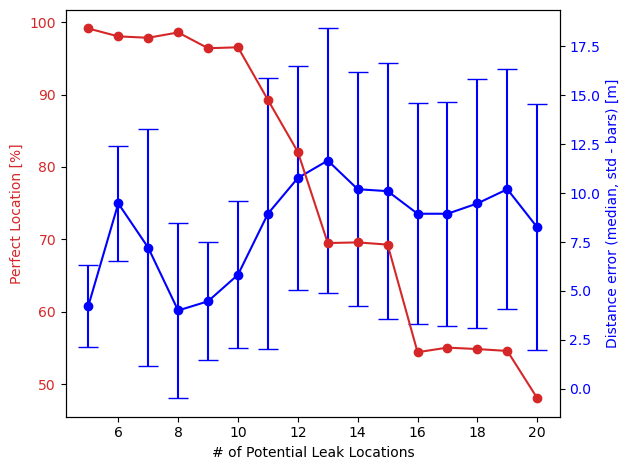

In [39]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('# of Potential Leak Locations')
ax1.set_ylabel('Perfect Location [%]', color=color)
ax1.plot(potleaks_v,error_conf_v[cc,:],'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_zorder(1)
ax1.patch.set_visible(False)

ax2 = ax1.twinx()
color = 'blue' # 'tab:blue'
ax2.set_ylabel('Distance error (median, std - bars) [m]', color=color)
ax2.errorbar(potleaks_v,error_conf_dist_v[cc,:,0],yerr=error_conf_dist_v[cc,:,1],marker='o',color=color,capsize=7.5,zorder=0)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()